In [1]:
import site
site.addsitedir(r'D:\mytools\AI4Water')

try:
    import AI4Water
except ImportError:
    pass #!python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git@dev"

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


c:\users\user\anaconda3\envs\tfcpu23_py37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)



**********Pytorch models could not be imported **********



In [2]:
import os

import numpy as np 
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
seed = 313
np.random.seed(seed)

In [5]:
from AI4Water import DualAttentionModel
from AI4Water.utils.datasets import CAMELS_AUS
from AI4Water.utils.utils import dateandtime_now
from AI4Water.utils.utils import Jsonize
from AI4Water.utils.visualizations import Interpret

In [6]:
dataset = CAMELS_AUS()

inputs = ['et_morton_point_SILO',
           'precipitation_AWAP',
           'tmax_AWAP',
           'tmin_AWAP',
           'vprp_AWAP',
           'rh_tmax_SILO',
           'rh_tmin_SILO'
          ]

outputs = ['streamflow_MLd']

data = dataset.fetch('401203', dynamic_attributes=inputs+outputs)
data = data['401203']
data.head()

,et_morton_point_SILO,precipitation_AWAP,tmax_AWAP,tmin_AWAP,vprp_AWAP,rh_tmax_SILO,rh_tmin_SILO,streamflow_MLd
1957-01-01,8.062837,0.0,20.784480,4.358533,8.142806,28.888577,88.900993,538.551
1957-01-02,8.519483,0.0,27.393169,4.835900,5.281136,23.516738,99.002080,531.094
1957-01-03,9.879688,0.0,28.945301,8.175408,12.920509,19.434872,77.429917,503.011
1957-01-04,6.744638,0.0,26.133843,7.017990,13.951027,42.350667,100.000000,484.512
1957-01-05,8.135359,0.0,21.450775,8.686258,12.168659,30.374862,87.634483,463.416


In [7]:
data.shape

(22645, 8)

In [8]:
(data['streamflow_MLd'].values<0.0).sum()

0

In [9]:
(data['streamflow_MLd'].values==0.0).sum()

0

In [10]:
data.isna().sum()

et_morton_point_SILO       0
precipitation_AWAP       365
tmax_AWAP                365
tmin_AWAP                365
vprp_AWAP                365
rh_tmax_SILO               0
rh_tmin_SILO               0
streamflow_MLd          1461
dtype: int64

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

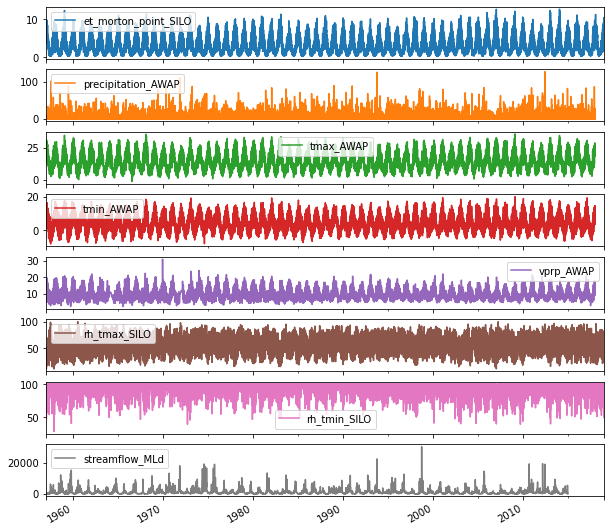

In [11]:
data.plot(subplots=True, sharex=True, figsize=(10, 10))

In [12]:
def objective_fn(return_model=False,
                 prefix=None,
                 **suggestion):

    suggestion = Jsonize(suggestion)()

    _model = DualAttentionModel(
                    data=data,
                    inputs=inputs,
                    outputs=outputs,
                    patience=50,
                    epochs=500,
                    lookback=int(suggestion['lookback']),
                    lr=suggestion['lr'],
                    batch_size=int(suggestion['batch_size']),
                    transformation=[{'method': 'robust', 'features': inputs},
                                    {'method': 'log', "replace_nans": True, "replace_zeros": True, 'features': outputs},
                                    {'method': 'robust', "replace_nans": True, 'features': outputs}
                                    ],
                    prefix=prefix
                    )

    h = _model.fit(indices='random')
    min_val_loss = float(np.min(h.history['val_loss']))
    print(f'with {suggestion} min val loss is {min_val_loss}')

    if return_model:
        return _model
    return _model


In [13]:
model = objective_fn(return_model=True,
                     lookback=15, lr=0.0001, batch_size=64)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 15, 7)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 7)            0           enc_input[0][0]                  
__________________________________________________________________________________________________
enc_first_hidden_state_1 (Input [(None, 20)]         0                                            
__________________________________________________________________________________________________
enc_first_cell_state_1 (InputLa [(None, 20)]         0                                            
_______________________________________________________________________________________

Executables None, dot.bat -Tpng C:\Users\USER\AppData\Local\Temp\tmp6sjhlld8

********** Removing Samples with nan labels  **********

input_x shape:  [(16935, 15, 7), (16935, 14, 1), (16935, 20), (16935, 20), (16935, 30), (16935, 30)]
target shape:  (16935, 1, 1)
Train on 13548 samples, validate on 3387 samples
Epoch 1/500
13376/13548 [============================>.] - ETA: 0s - loss: 0.3583 - nse: 0.3047WARNING:tensorflow:From c:\users\user\anaconda3\envs\tfcpu23_py37\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
13548/13548 [==============================] - 17s 1ms/sample - loss: 0.3570 - nse: 0.3078 - val_loss: 0.2728 - val_nse: 0.4803
Epoch 2/500
13548/13548 [==============================] - 4s 261us/sample - loss: 0.239

13548/13548 [==============================] - 4s 262us/sample - loss: 0.0118 - nse: 0.9767 - val_loss: 0.0125 - val_nse: 0.9762
Epoch 54/500
13548/13548 [==============================] - 3s 252us/sample - loss: 0.0117 - nse: 0.9770 - val_loss: 0.0133 - val_nse: 0.9744
Epoch 55/500
13548/13548 [==============================] - 4s 262us/sample - loss: 0.0114 - nse: 0.9777 - val_loss: 0.0123 - val_nse: 0.9767
Epoch 56/500
13548/13548 [==============================] - 4s 266us/sample - loss: 0.0113 - nse: 0.9778 - val_loss: 0.0122 - val_nse: 0.9772
Epoch 57/500
13548/13548 [==============================] - 4s 260us/sample - loss: 0.0112 - nse: 0.9781 - val_loss: 0.0121 - val_nse: 0.9768
Epoch 58/500
13548/13548 [==============================] - 4s 262us/sample - loss: 0.0111 - nse: 0.9783 - val_loss: 0.0119 - val_nse: 0.9773
Epoch 59/500
13548/13548 [==============================] - 4s 262us/sample - loss: 0.0109 - nse: 0.9786 - val_loss: 0.0117 - val_nse: 0.9778110 - nse: 0.97
Epoc

13548/13548 [==============================] - 4s 267us/sample - loss: 0.0085 - nse: 0.9832 - val_loss: 0.0108 - val_nse: 0.9796
Epoch 111/500
13548/13548 [==============================] - 4s 272us/sample - loss: 0.0086 - nse: 0.9830 - val_loss: 0.0106 - val_nse: 0.9799
Epoch 112/500
13548/13548 [==============================] - 4s 279us/sample - loss: 0.0084 - nse: 0.9833 - val_loss: 0.0113 - val_nse: 0.9784
Epoch 113/500
13548/13548 [==============================] - 4s 269us/sample - loss: 0.0084 - nse: 0.9835 - val_loss: 0.0106 - val_nse: 0.9799
Epoch 114/500
13548/13548 [==============================] - 4s 276us/sample - loss: 0.0084 - nse: 0.9835 - val_loss: 0.0104 - val_nse: 0.9803
Epoch 115/500
13548/13548 [==============================] - 4s 267us/sample - loss: 0.0083 - nse: 0.9836 - val_loss: 0.0107 - val_nse: 0.9795
Epoch 116/500
13548/13548 [==============================] - 4s 268us/sample - loss: 0.0083 - nse: 0.9836 - val_loss: 0.0106 - val_nse: 0.9800
Epoch 117/500

13548/13548 [==============================] - 4s 268us/sample - loss: 0.0071 - nse: 0.9860 - val_loss: 0.0103 - val_nse: 0.9803
Epoch 168/500
13548/13548 [==============================] - 4s 267us/sample - loss: 0.0070 - nse: 0.9860 - val_loss: 0.0104 - val_nse: 0.9804
Epoch 169/500
13548/13548 [==============================] - 4s 269us/sample - loss: 0.0070 - nse: 0.9861 - val_loss: 0.0103 - val_nse: 0.9806
Epoch 170/500
13548/13548 [==============================] - 4s 268us/sample - loss: 0.0070 - nse: 0.9863 - val_loss: 0.0106 - val_nse: 0.9800
Epoch 171/500
13548/13548 [==============================] - 4s 268us/sample - loss: 0.0070 - nse: 0.9861 - val_loss: 0.0105 - val_nse: 0.9803
Epoch 172/500
13548/13548 [==============================] - 4s 268us/sample - loss: 0.0070 - nse: 0.9863 - val_loss: 0.0105 - val_nse: 0.9800
Epoch 173/500
13548/13548 [==============================] - 4s 268us/sample - loss: 0.0069 - nse: 0.9864 - val_loss: 0.0105 - val_nse: 0.9800
Epoch 174/500

Making predictions on training data


********** Removing Samples with nan labels  **********

input_x shape:  [(16935, 15, 7), (16935, 14, 1), (16935, 20), (16935, 20), (16935, 30), (16935, 30)]
target shape:  (16935, 1, 1)


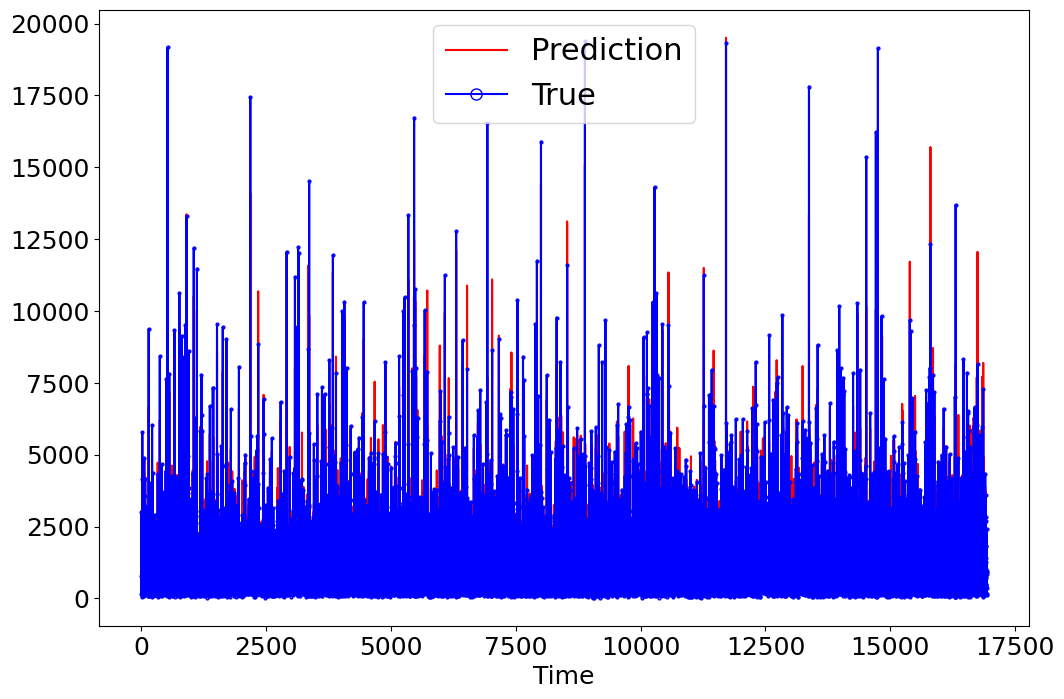

In [17]:
_ = model.predict(indices=model.train_indices, prefix='train')

Making predictions on test data


********** Removing Samples with nan labels  **********

input_x shape:  [(4234, 15, 7), (4234, 14, 1), (4234, 20), (4234, 20), (4234, 30), (4234, 30)]
target shape:  (4234, 1, 1)


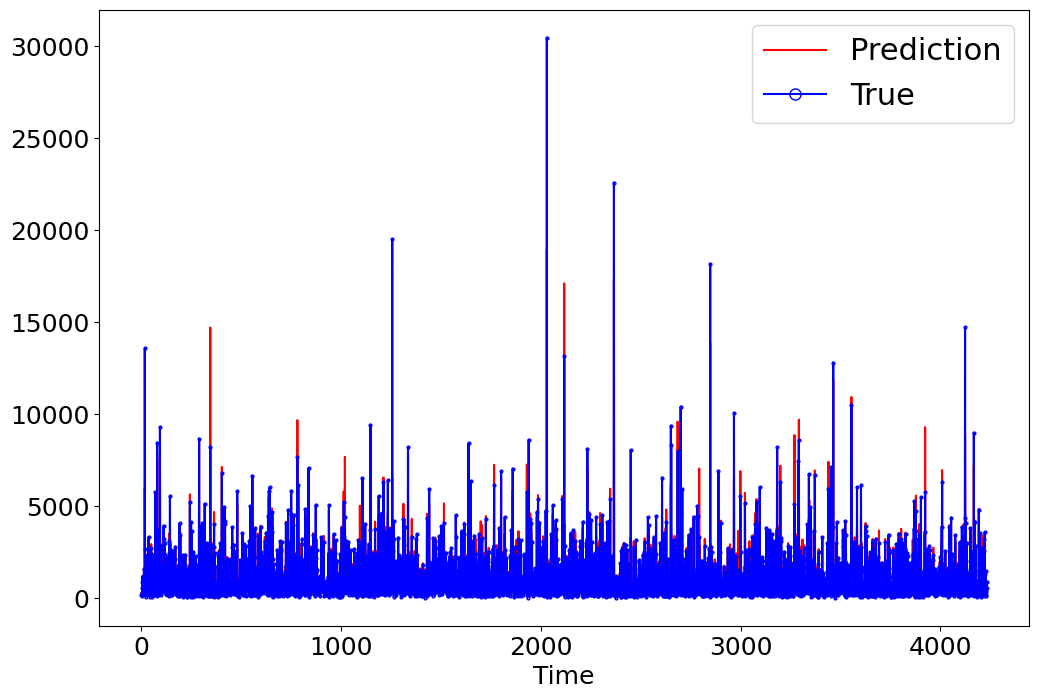

In [18]:
_ = model.predict(indices=model.test_indices, prefix='test')

Getting interpretable results

In [16]:
Interpret(model)


********** Removing Samples with nan labels  **********

input_x shape:  [(21170, 15, 7), (21170, 14, 1), (21170, 20), (21170, 20), (21170, 30), (21170, 30)]
target shape:  (21170, 1, 1)

********** Removing Samples with nan labels  **********

input_x shape:  [(21170, 15, 7), (21170, 14, 1), (21170, 20), (21170, 20), (21170, 30), (21170, 30)]
target shape:  (21170, 1, 1)


In [19]:
print(f'All results are saved in {model.path}')

All results are saved in D:\mytools\AI4Water\examples\paper_figs\results\20210601_140418
